# Libraries

In [0]:
import cloudpickle as pickle

In [0]:
import numpy as np
import pandas as pd
import sklearn

In [0]:
import tensorflow as tf
import keras

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
import matplotlib.pyplot as plt

# Loading the data

#### UPLOAD THE MAIN ZIP HERE CONTAINING THE FOLDERS TRAINSET AND TESTSET





In [6]:
from google.colab import files
uploaded = files.upload()

Saving mnist.zip to mnist.zip


In [0]:
# Extract the zip locally
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['mnist.zip']), 'r')
data.extractall()

In [8]:
# Verify that you have a folder testset and trainset here
import os
!ls
os.getcwd()

kaggle_cat_dog.zip  mnist.pkl.gz  models       testset
mnist.pkl	    mnist.zip	  sample_data  trainset


'/content'

In [9]:
os.listdir(os.path.join('/content', 'trainset'))

['Cat', '.DS_Store', 'Dog']

## Define paths

In [0]:
data_path = '/content/mnist.pkl'

In [0]:
with open(data_path, 'rb') as f:
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = pickle.load(f, encoding='latin-1')

In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)
(10000, 784)
(10000,)


In [0]:
x_train = x_train.reshape((50000, 28, 28, 1))
x_val = x_val.reshape((10000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

In [0]:
encoder = OneHotEncoder(categories=[range(10)], sparse=False)

In [15]:
encoder.fit(np.array([0,1,2,3,4,5,6,7,8,9]).reshape(10,1))

OneHotEncoder(categorical_features=None, categories=[range(0, 10)],
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)

In [0]:
y_train = encoder.transform(y_train.reshape(len(y_train), 1))
y_val = encoder.transform(y_val.reshape(len(y_val), 1))
y_test = encoder.transform(y_test.reshape(len(y_test), 1))

In [17]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)
(10000, 10)


# Keras

In [0]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

As keras makes an approximation of the training accuracy and loss during training by averaging the values obtained by each bach, we had to manually ask Keras to output the real training accuracy and loss. This is why we run epoch by epoch during training and not using the built in ability of Keras of computing several epochs at once.

## First model with 2 conv but 25k parameters

In [0]:
class CNN1:
    
    def __init__(self):
        np.random.seed(0)
        tf.set_random_seed(0)
        self.model = keras.models.Sequential()
        self.history = {'epochs': 0, 'loss': [], 'val_loss': [], 'acc': [], 'val_acc':[]}
        
        # Layer 1
        self.model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', use_bias=True,
                              activation='relu', input_shape=(28,28,1), data_format='channels_last'))
        self.model.add(MaxPooling2D(2, padding='valid', data_format='channels_last'))
        
        # Layer 2
        self.model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', use_bias=True,
                              activation='relu', input_shape=(14,14,32), data_format='channels_last'))
        self.model.add(MaxPooling2D(2, padding='valid', data_format='channels_last'))
        
        # Flattening
        self.model.add(Flatten())
        
        # Layer 3
        self.model.add(Dense(10, use_bias=True, activation='softmax'))
        
        sgd = keras.optimizers.SGD(lr=0.01)
        self.model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
        
        self.model.summary()
    
    def train(self, x_tr, y_tr, x_v, y_v, ep, bs=32):
        for _ in range(ep):
            self.model.fit(x_tr, y_tr, validation_data=(x_v, y_v), epochs=1, batch_size=bs)
            self.history['epochs'] += 1
            loss, acc = self.model.evaluate(x_train, y_train)
            val_loss, val_acc = self.model.evaluate(x_val, y_val)
            text_status = "Real status --- Epoch: {}".format(self.history['epochs'])
            for key in ['loss', 'acc', 'val_loss', 'val_acc']:
                self.history[key].append(eval(key))
                text_status += " - {0}: {1}".format(key, round(eval(key), 4))
            print(text_status+'\n')

In [20]:
mod1 = CNN1()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                15690     
Total params: 25,258
Trainable params: 25,258
Non-trainable params: 0


In [21]:
mod1.train(x_train, y_train, x_val, y_val, 10)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 73us/step
Real status --- Epoch: 1 - loss: 0.2986 - acc: 0.906 - val_loss: 0.2719 - val_acc: 0.9177

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 80us/step
Real status --- Epoch: 2 - loss: 0.1725 - acc: 0.9485 - val_loss: 0.1599 - val_acc: 0.9544

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 73us/step
Real status --- Epoch: 3 - loss: 0.116 - acc: 0.966 - val_loss: 0.1082 - val_acc: 0.9711

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 73us/step
Real status --- Epoch: 4 - loss: 0.0923 - acc: 0.9727 - val_loss: 0.0926 - val_acc: 0.9748

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 

Plotting the accuracy and the loss function at each epoch:

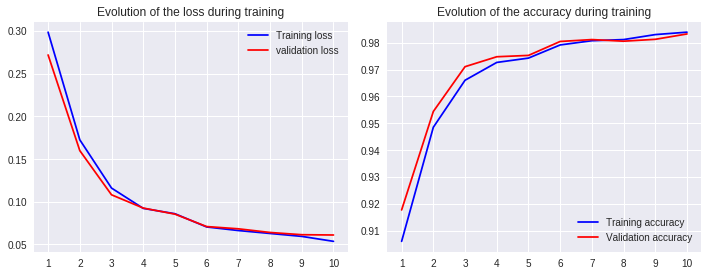

In [22]:
history = mod1.history
epochs = history['epochs']

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], color='b', label="Training loss")
plt.plot(history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the loss during training')

plt.subplot(1, 2, 2)
plt.plot(history['acc'], color='b', label="Training accuracy")
plt.plot(history['val_acc'], color='r',label="Validation accuracy")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the accuracy during training')

plt.tight_layout()
plt.show()

Checking the performances on the test set:

In [23]:
l, acc = mod1.model.evaluate(x_test, y_test)
print('Test loss:', l)
print('Test accuracy:', acc)

10000/10000 [==============================] - 1s 69us/step
Test loss: 0.05527564362438861
Test accuracy: 0.9817


As we have just seen, we don't even need that many parameters to beat the MLP we built in the first part. In order to follow the guidelines, we still built a convolutional neural net with as many parameters as the one we built in the first part.

***

## Second model with 3 conv and 600k parameters (to compare with MLP)

In [0]:
class CNN2:
    
    def __init__(self):
        np.random.seed(0)
        tf.set_random_seed(0)
        self.model = keras.models.Sequential()
        self.history = {'epochs': 0, 'loss': [], 'val_loss': [], 'acc': [], 'val_acc':[]}
        
        # Layer 1
        self.model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=True,
                              activation='relu', input_shape=(28,28,1), data_format='channels_last'))
        self.model.add(MaxPooling2D(2, padding='valid', data_format='channels_last'))
        
        # Layer 2
        self.model.add(Conv2D(128, kernel_size=3, strides=1, padding='same', use_bias=True,
                              activation='relu', input_shape=(14,14,32), data_format='channels_last'))
        
        # Layer 3
        self.model.add(Conv2D(128, kernel_size=3, strides=1, padding='same', use_bias=True,
                              activation='relu', input_shape=(14,14,32), data_format='channels_last'))
        self.model.add(MaxPooling2D(2, padding='valid', data_format='channels_last'))
        
        # Flattening
        self.model.add(Flatten())
        
        # Layer 4
        self.model.add(Dense(64, use_bias=True, activation='relu'))
        
        # Layer 5
        self.model.add(Dense(10, use_bias=True, activation='softmax'))
        
        sgd = keras.optimizers.SGD(lr=0.01)
        self.model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
        
        self.model.summary()
    
    def train(self, x_tr, y_tr, x_v, y_v, ep, bs=32):
        for _ in range(ep):
            self.model.fit(x_tr, y_tr, validation_data=(x_v, y_v), epochs=1, batch_size=bs)
            self.history['epochs'] += 1
            loss, acc = self.model.evaluate(x_train, y_train)
            val_loss, val_acc = self.model.evaluate(x_val, y_val)
            text_status = "Real status --- Epoch: {}".format(self.history['epochs'])
            for key in ['loss', 'acc', 'val_loss', 'val_acc']:
                self.history[key].append(eval(key))
                text_status += " - {0}: {1}".format(key, round(eval(key), 4))
            print(text_status+'\n')

In [25]:
mod2 = CNN2()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                401472    
__________

In [26]:
mod2.train(x_train, y_train, x_val, y_val, 10)

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 136us/step
Real status --- Epoch: 1 - loss: 0.1961 - acc: 0.9373 - val_loss: 0.1802 - val_acc: 0.9429

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 124us/step
Real status --- Epoch: 2 - loss: 0.1001 - acc: 0.9699 - val_loss: 0.0974 - val_acc: 0.972

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 130us/step
Real status --- Epoch: 3 - loss: 0.07 - acc: 0.9784 - val_loss: 0.0724 - val_acc: 0.9787

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 125us/step
Real status --- Epoch: 4 - loss: 0.0567 - acc: 0.9831 - val_loss: 0.0641 - val_acc: 0.9826

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 129us/step
Real status --- Epoch: 5 - los

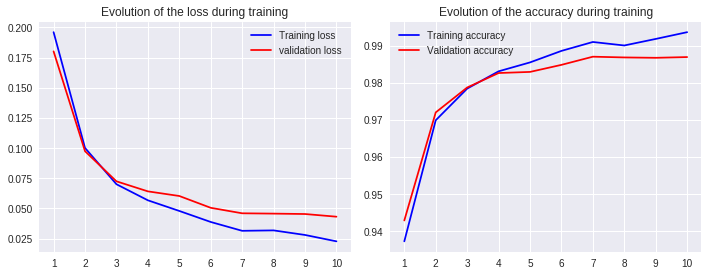

In [27]:
history = mod2.history
epochs = history['epochs']

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], color='b', label="Training loss")
plt.plot(history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the loss during training')

plt.subplot(1, 2, 2)
plt.plot(history['acc'], color='b', label="Training accuracy")
plt.plot(history['val_acc'], color='r',label="Validation accuracy")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the accuracy during training')

plt.tight_layout()
plt.show()

In [28]:
l, acc = mod1.model.evaluate(x_test, y_test)
print('Test loss:', l)
print('Test accuracy:', acc)

10000/10000 [==============================] - 1s 71us/step
Test loss: 0.05527564362438861
Test accuracy: 0.9817


We reached 97% accuracy on the second epoch !